In [6]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [7]:
#starship specs
isp = 380
dry_mass = 90
prop_mass = 1500 #tons
lmo_fuel = 250


# landing_reserve = 500

starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
# boiloff = 0#0 
print(starship_dv)

# #for a skimpy 100t starship, only need 20 tons of landing fuel
# print(isp*9.81*math.log((120)/(100)))



10705.047305642622


Ejection is with 9049m/s of DV (in sun reference frame, so actual number is different)
departure from Earth (♁) on 2030-01-18 00:02:09.185
arrival at Jupiter (♃) on 2031-12-19 00:02:09.185


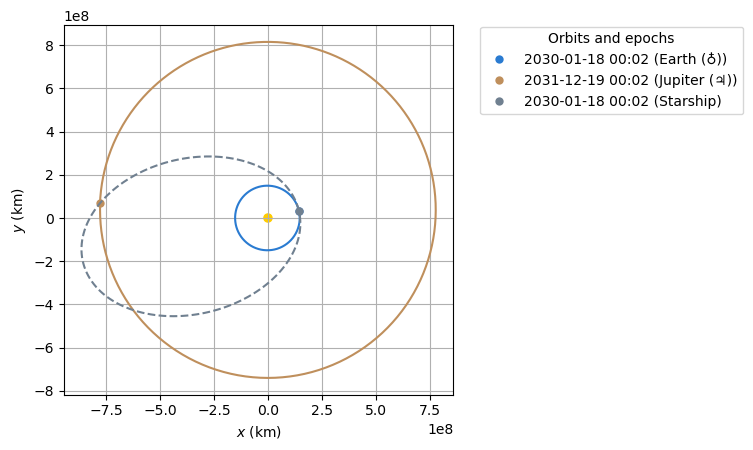

In [8]:

#launch from body_1 to body_2
body_1 = Earth
body_2 = Jupiter


#starship specs
isp = 370
dry_mass = 103
prop_mass = 2000
landing_reserve = 500
if(body_2 == Earth):
    landing_reserve = 300#less DV needed for Earth landing

starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
boiloff = 0#0 




#solve for a minimum ejection DV given a time period
transitTime = 700*u.day
resolution = 1*u.day
start_date = time.Time("2025-02-15 00:01", scale="utc").tdb
end_date = time.Time("2045-02-17 00:01", scale="utc").tdb

ephem_1 = Ephem.from_body(body_1, time_range(start_date, end=end_date+transitTime))
ephem_2 = Ephem.from_body(body_2, time_range(start_date, end=end_date+transitTime))


delta_time = end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
for i in range(int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = start_date+transitTime+i*resolution
    # Solve for departure and target orbits
    ss_planet_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)
    ss_planet_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)

    # Solve for the transfer maneuver
    man_lambert = Maneuver.lambert(ss_planet_1, ss_planet_2)
    ejection = man_lambert[0]
    dv = np.linalg.norm(ejection[1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_launch
        lowest_orb,final = ss_planet_1.apply_maneuver(man_lambert, intermediate=True)


reserve_dv = starship_dv-int(lowest_dv)-landing_reserve
#print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection is with {int((1-boiloff)*lowest_dv)}m/s of DV (in sun reference frame, so actual number is different)")
#print(f"Reserve DV (not accounting for boiloff) is {reserve_dv}m/s")
print(f"departure from {body_1} on {lowest_date}")
print(f"arrival at {body_2} on {lowest_date+transitTime}")
      
dM = 0*u.day

fig, ax = plt.subplots()

ax.grid(True)
#ax.set_title("2033 90 day trajectory")

# We can check new bodies positions
plotter = StaticOrbitPlotter(ax)
ss_leave_1 = Orbit.from_ephem(Sun, ephem_1, lowest_date)
ss_arrival_2 = Orbit.from_ephem(Sun, ephem_2, lowest_date+transitTime)

plotter.plot_body_orbit(body_1,  lowest_date+dM, label=body_1)

plotter.plot_body_orbit(body_2,  lowest_date+dM+transitTime, label=body_2)
label_str = lowest_date.datetime.strftime("%Y-%m-%d")


#plotter.plot(ss_leave_1, label=label_str)

plotter.plot(lowest_orb, color="slategrey", label="Starship")

In [9]:
#calculate total boiloff during trip
starship_albedo = 0.1
#approxing solar irradiance with tanh between body 1 and body 2
def sig_rad(dT):
    return (math.exp(dT)-math.exp(-dT))/(math.exp(dT)+math.exp(-dT))



In [10]:
#Find SOI change on departure
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_1.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_1.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference>0):
        print(f"Departure at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Departed SOI on {soi_change_point}")



70300 steps
Departure at step8
Departed SOI on 2030-01-18 01:57:21.185


Soi change at 271698.72307096433 km (potentially seems low tbf)
C3 is 81.90855082953789 km2 / s2
Ejection towards Jupiter (♃) from Earth (♁)
Starship DV is 10948.595093170981m/s
Ejection velocity is 14.283775022094185 km / s
Ejection DV is 6.4697594714229485 km / s
Ejection C3 is 81.9085508295379
Starship has 3978.835621748033 m / s of DV after the burn excluding landing reserve (500 m/s)


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



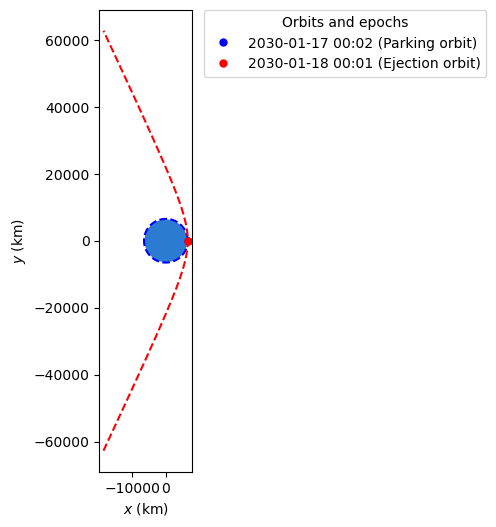

In [11]:
ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_1, v_body_1 = ss_body_1.r,ss_body_1.v
r_sc_arriv = ss_final.r-r_body_1
v_sc_arriv = ss_final.v-v_body_1
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 150*u.km#parking orbit

parking_orbit = Orbit.circular(body_1,alt = r_p,epoch = date_launch-1*u.day)


a_exit = -(body_1.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_1.R) / a_exit

departure_orbit = Orbit.from_classical(
    body_1,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_launch, scale="utc"),
)
print(f"Ejection towards {body_2} from {body_1}")
print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection velocity is {np.linalg.norm(departure_orbit.v)}")
print(f"Ejection DV is {np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)}")
ejection_c3 = -(body_1.k/(departure_orbit.a.to(u.m))).value/1000000
print(f"Ejection C3 is {ejection_c3}")



ejection_dv = (np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)).value
reserve_dv = starship_dv-(ejection_dv*1000)-landing_reserve
print(f"Starship has {reserve_dv} m / s of DV after the burn excluding landing reserve ({landing_reserve} m/s)")

earth_plotter = StaticOrbitPlotter()

earth_plotter.plot(parking_orbit, label="Parking orbit", color="b")
earth_plotter.plot(departure_orbit, label="Ejection orbit", color="r")


In [12]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_2.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_2.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference<0):
        print(f"arrival at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Normal arrival would be {date_arrival}")
print(f"Actual arrival at {soi_change_point}")



70300 steps
arrival at step67031
Normal arrival would be 2031-12-19 00:02:09.185
Actual arrival at 2031-11-19 07:28:33.185


Soi change at 23665755.213351388 km (potentially seems low tbf)
C3 is 72.41006066486092 km2 / s2
Arrival speed (at periapsis) would be 59.979135119765665 km / s
Burn is 3978.835621748033 m/s
After deacceleration burn it is 59.979135119765665 km / s
Pre Entry orbit characteristics are periapsis 399.99999999998545 km and apoapsis -3643250.216559867 km
Entry C3 is 72.4100606648617 km^2/s^2
Sus C3 is -42.2151623616046 km2 / s2
Need to lose 0.4469950542707082 km / s in initial aerocapture pass
Time for light to travel from Earth (♁) to Jupiter (♃) at arrival time is 47.7 minutes


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



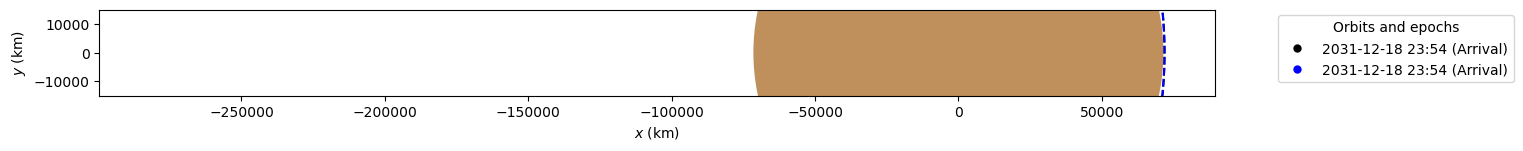

In [13]:
#ITS BROKEN AND I UNDERSTAND WHY



retro_time = 400*u.second #how long before entry interface to do the retro burn

ss_final = lowest_orb.propagate(soi_change_point-date_launch) 

b1_arrival_1 = Orbit.from_ephem(Sun, ephem_1, lowest_date+transitTime)
b1_arrival_2 = Orbit.from_ephem(Sun, ephem_2, lowest_date+transitTime)
planDist = np.linalg.norm((b1_arrival_1.r-b1_arrival_2.r).value)

r_body_2, v_body_2 = ss_body_2.r,ss_body_2.v
r_sc_arriv = ss_final.r-r_body_2
v_sc_arriv = ss_final.v-v_body_2
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 400*u.km#arrival periapsis
a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

arrival_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)


pre_burn_orbit = arrival_orbit.propagate(-retro_time)
#perform the retro burn
prograde_vector = (pre_burn_orbit.v/(np.linalg.norm(pre_burn_orbit.v))).value
#offset by a little as we dont want periapsis going into the atmosphere
rad_vector = (pre_burn_orbit.r/(np.linalg.norm(pre_burn_orbit.r))).value
rad_offset_weight = 0.1
retro_vector = -(prograde_vector-rad_offset_weight*rad_vector)
retro_vector = retro_vector/np.linalg.norm(retro_vector)

# print(prograde_vector)


##no deaccleration burn for arriving at Earth for now


burn_dv = 0*0.001*reserve_dv*(retro_vector)
#print(burn_dv)
# else:
#     burn_dv = 0*prograde_vector

retro_burn = Maneuver((0*u.s,burn_dv*u.km/u.s))
#retro_burn = Maneuver((0*u.s,[0,1,0]*u.km/u.s))
post_burn_orbit = pre_burn_orbit.apply_maneuver(retro_burn)

#print(f"New periapsis is {post_burn_orbit.r_p-body_2.R}km")

ax = plt.gca()       # or plotter.ax if you stored it directly
ax.set_ylim([-1.5e4, 1.5e4]) 

earth_plotter = StaticOrbitPlotter(ax)

#print(f"State vectors post burn are {post_burn_orbit.r} and {post_burn_orbit.v}.")



earth_plotter.plot(pre_burn_orbit, label="Arrival", color="k")
#earth_plotter.

# print(post_burn_orbit.v)
# print(post_burn_orbit.r)

post_burn_orbit_periapsis = post_burn_orbit.propagate(-post_burn_orbit.t_p)
earth_plotter.plot(post_burn_orbit, label="Arrival", color="b")

arrival_circular_orbit = Orbit.circular(body_2,alt = 200*u.km)


print(f"Arrival speed (at periapsis) would be {np.linalg.norm(arrival_orbit.v)}")
print(f"Burn is {reserve_dv} m/s")
print(f"After deacceleration burn it is {np.linalg.norm(post_burn_orbit_periapsis.v)}")
print(f"Pre Entry orbit characteristics are periapsis {post_burn_orbit.r_p-body_2.R} and apoapsis {post_burn_orbit.r_a-body_2.R}")

#post_burn_c3 = ((np.linalg.norm(post_burn_orbit.v)-(body_2.escape_velocity()))**2)

post_burn_c3 = -(body_2.k/(post_burn_orbit.a.to(u.m))).value/1000000
#something unknown that is likely wrong
sus_c3 = (np.linalg.norm(post_burn_orbit.v)**2-body_2.escape_velocity()**2)



print(f"Entry C3 is {post_burn_c3} km^2/s^2")
print(f"Sus C3 is {sus_c3}")


print(f"Need to lose {np.linalg.norm(post_burn_orbit_periapsis.v)-body_2.escape_velocity()} in initial aerocapture pass")

print(f"Time for light to travel from {body_1} to {body_2} at arrival time is {planDist/(3*1e5*60):.1f} minutes")


####code below tries to calculate real orbit, but patched conics problems force a c3 only calculation orbit tbf

# #grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-Earth.mass/(np.linalg.norm(r_sc_arriv)**2)
# print(grav_difference)

# arrival_orbit = Orbit.from_vectors(Earth,r_sc_arriv,v_sc_arriv,epoch=date_arrival-offset_time)
# #arrival_orbit = arrival_orbit.propagate(0.3*u.day)
# print(arrival_orbit)
# print(f"This orbit gets to within {arrival_orbit.r_p-Earth.R} of the surface of earth")
# print(f"Earth position at {lowest_date}")

# earth_plotter = StaticOrbitPlotter()

# earth_plotter.plot(arrival_orbit, label="earth Arrival", color="k")



In [14]:
# #for the optimized trajectory, re get the epherimis
# date_launch = lowest_date
# date_arrival = lowest_date+transitTime
# ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
# ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)




# #ejection from Earth
# #calculate departure orbit
# prop_time = 0.012*u.day

# ss_leave = lowest_orb.propagate(prop_time)
# r_earth,v_earth=ss_earth.r,ss_earth.v
# r_traj_leave = ss_leave.r-r_earth
# v_traj_leave = ss_leave.v-v_earth


# ejection_orbit = Orbit.from_vectors(Earth,r_traj_leave,v_traj_leave,epoch = date_launch)
# #ejection_orbit.inc = 0*u.rad
# #propogate ejection_orbit to periapsis



# parking_orbit = Orbit.circular(Earth,inc=0*u.rad, alt=300 << u.km,epoch = date_launch)



# print(ejection_orbit.energy)# = 0*u.rad
# print(parking_orbit.energy)

# #calculate ejection DV
# #print(parking_orbit.v)
# dE = ejection_orbit.energy-parking_orbit.energy
# dV=np.sqrt(dE)
# print(f"Ejection DV is {dV}")


# print(parking_orbit)
# print(ejection_orbit)
# earth_ejection_plotter = StaticOrbitPlotter()

# ejection_orbit.inc = 0*u.rad
# earth_ejection_plotter.plot(parking_orbit, label="Parking Orbit", color="b")
# earth_ejection_plotter.plot(ejection_orbit, label="Ejection Orbit", color="k")

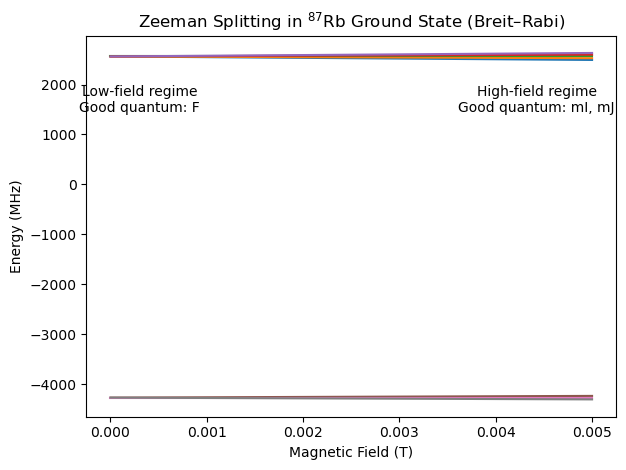

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
mu_B = 9.274009994e-24       # Bohr magneton (J/T)
mu_N = 5.050783699e-27       # Nuclear magneton (J/T)
h = 6.62607015e-34           # Planck constant (J·s)
I = 3/2
J = 1/2
g_J = 2.00233113
g_I = -0.0009951414
A_hfs = 6.83468261090429e9   # Hyperfine splitting (Hz)

def breit_rabi(B):
    # Breit–Rabi energies (Hz) relative to center-of-gravity
    x = (g_J*mu_B - g_I*mu_N) * B / (h * A_hfs)
    E0 = -A_hfs / (2 * (2*I + 1))
    energies = {}
    for sign, F in [('+', I+J), ('-', I-J)]:
        for mF in np.arange(-F, F+1):
            term = np.sqrt(1 + (4 * mF * x) / (2*I + 1) + x**2)
            E = E0 + (g_I * mu_N * B * mF) / h + (A_hfs/2) * (term if sign=='+' else -term)
            energies[(sign, mF)] = E
    return energies

# Range of magnetic fields (T)
B_vals = np.linspace(0, 0.005, 800)

# Compute energies (convert to MHz)
levels = list(breit_rabi(0).keys())
energies = {lvl: [] for lvl in levels}
for B in B_vals:
    br = breit_rabi(B)
    for lvl in levels:
        energies[lvl].append(br[lvl] / 1e6)

# Plot
plt.figure()
for E in energies.values():
    plt.plot(B_vals, E)

plt.xlabel('Magnetic Field (T)')
plt.ylabel('Energy (MHz)')
plt.title('Zeeman Splitting in $^{87}$Rb Ground State (Breit–Rabi)')

# Mark regimes
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
plt.text(x0 + 0.1*(x1-x0), y0 + 0.8*(y1-y0), 'Low-field regime\nGood quantum: F',
         ha='center')
plt.text(x0 + 0.85*(x1-x0), y0 + 0.8*(y1-y0), 'High-field regime\nGood quantum: mI, mJ',
         ha='center')

plt.tight_layout()
plt.show()
